#Skin Cancer segmentation using Unet
whole model trained from scratch

In [0]:
import torch
import numpy as np
import pandas as pd
import os
import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path='/content/drive/My Drive/DATA/DATA/'

## Load Pickled Data
We've rescaled the image data to the range [0.0, 1.0] and stored as a pickle for fast loading

In [0]:
train_img_x,train_img_y,val_img_x,val_img_y=pickle.load(open('/content/drive/My Drive/DATA/cancer_rescaled.pkl',mode='rb'))
test_img_x, test_img_y = pickle.load(open('/content/drive/My Drive/DATA/test.pkl', mode='rb'))

print(train_img_x.max(), val_img_x.max(), test_img_x.max())
print(train_img_x.min(), val_img_x.min(), test_img_x.min())

tensor(1.) tensor(1.) tensor(1.)
tensor(0.) tensor(0.) tensor(0.)


## Model Construction

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.AvgPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [0]:
import random

def get_batches(bs):
    idxs = np.random.permutation(len(train_img_x))

    for i in tqdm.tqdm(range(0, len(idxs) - bs + 1, bs)):
        res_x, res_y = train_img_x[ idxs[i:i+bs] ].clone(), train_img_y[ idxs[i:i+bs] ].clone()

        #randomly choose between 4 options:
        c = random.randint(0, 3)

        if c == 0:
            #leave image as is
            yield res_x, res_y
        elif c == 1:
            #flip sideways
            yield res_x.flip(2), res_y.flip(1)
        elif c == 2:
            #flip upwards
            yield res_x.flip(3), res_y.flip(2)
        elif c == 3:
            #flip both sideways and upwards. In effect, do a 180° turn
            yield res_x.flip(3).flip(2), res_y.flip(2).flip(1)

def get_batches_small(bs):
    #for quick LR-Find
    idxs = np.random.permutation(300)

    for i in tqdm.tqdm(range(0, len(idxs) - bs + 1, bs)):
        yield train_img_x[ idxs[i:i+bs] ], train_img_y[ idxs[i:i+bs] ]

In [0]:
def get_val_loss_accuracy(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm.tqdm(zip(val_img_x, val_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = IoU_accuracy(preds.squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

def IoU_accuracy(y_preds, y_real, t=0.5, plot=False):
    '''Intersection over Union metric'''
    thres = torch.ByteTensor(y_preds > t)
    realz = torch.ByteTensor(y_real >= 0.5)

    intersect = (thres & realz).sum().float() 
    union = (thres | realz).sum().float()
    result = intersect / union
    # print(intersect, union, res)

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(thres)
        plt.subplot(3, 2, 2)
        plt.imshow(realz)

        plt.subplot(3, 2, 3)
        plt.imshow(thres & realz)
        plt.subplot(3, 2, 4)
        plt.imshow(thres | realz)

        plt.subplot(3, 2, 5)
        plt.imshow(y_preds)
        plt.subplot(3, 2, 6)
        plt.imshow(y_real)

    return result.item()

def Dice_accuracy(y_preds, y_real, t=0.5, plot=False):
    '''2 * Intersection / (real.sum() + prediction.sum())'''
    # print(y_preds.dtype, y_preds.shape)
    # print(tmp.dtype)
    thres = (y_preds > t).type(torch.ByteTensor)
    realz = y_real.type(torch.ByteTensor)

    intersect = (thres & realz).sum().float() 
    union = (thres | realz).sum().float() 
    result = (intersect + intersect) / (union + intersect)
    # print(intersect, union, res)

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(thres)
        plt.subplot(3, 2, 2)
        plt.imshow(realz)

        plt.subplot(3, 2, 3)
        plt.imshow(thres & realz)
        plt.subplot(3, 2, 4)
        plt.imshow(thres | realz)

        plt.subplot(3, 2, 5)
        plt.imshow(y_preds)
        plt.subplot(3, 2, 6)
        plt.imshow(y_real)

    return result.item()

In [0]:
def get_val_loss_accuracy_DICE(model, device='cuda'):
    model.eval()
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(zip(val_img_x, val_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = Dice_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

In [0]:
def train_loop(model, epochs=1, lr=0.005, bs=25, weight_decay=0.0, device='cuda'):
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  for epoch in range(epochs):
    loss_t=0
    for xb, yb in get_batches(bs=bs):
      model.train()
      
      preds = model(xb.to(device))
      preds=preds.squeeze(1)

      loss = bce_loss(preds,yb.to(device))
      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      loss_t += loss.detach()
      
    model.eval()

    val_loss, IoU_acc = get_val_loss_accuracy(model, device)
    val_losses.append(val_loss)
    accuracies.append(IoU_acc)

    train_losses.append(loss_t / (len(train_img_x) / bs))

    print("val_loss: {} | accuracy: {} | train_loss: {}".format(val_losses[-1], accuracies[-1], train_losses[-1]))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(val_losses, label='validation loss')
  plt.plot(train_losses, label='training loss')
  plt.legend(loc='upper right') 
  plt.subplot(1, 2, 2) 
  plt.plot(accuracies, label="accuracy")
  plt.legend(loc='upper right')
  plt.show()

In [0]:
find_losses = []

def train_loop_find(model, epochs=1, lr=0.006, bs=25, device='cuda'):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    loss_t=0
    for xb, yb in get_batches_small(bs=bs):

      model.train()
      
      preds = model(xb.to(device))
      preds=preds.squeeze(1)
    #   print(preds.shape, yb.shape)
      loss = bce_loss(preds,yb.to(device))
      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      loss_t += loss.detach()
      
    model.eval()
    print("lr : {} | train_loss: {}"
            .format(lr, loss_t / (len(train_img_x) / bs))
    )

    find_losses.append(loss_t / (len(train_img_x) / bs))

### Proper weight initialization speeds up training

In [0]:
import torch.nn.init as init

def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)

## Find an optimal LR range
The idea is to train single epochs on a small subset of data, and see which range for LR give the maximum slope.

  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0001 | train_loss: 0.09084675461053848


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0002 | train_loss: 0.07880948483943939


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0004 | train_loss: 0.07949318736791611


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0006 | train_loss: 0.07394874840974808


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0008 | train_loss: 0.06781654804944992


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.001 | train_loss: 0.06134868785738945


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.002 | train_loss: 0.06026902422308922


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.004 | train_loss: 0.05286605283617973


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.006 | train_loss: 0.05174216255545616


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.008 | train_loss: 0.051940303295850754


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.01 | train_loss: 0.05633135512471199


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.02 | train_loss: 0.062318701297044754


100%|██████████| 12/12 [00:17<00:00,  1.52s/it]


lr : 0.04 | train_loss: 0.06367635726928711


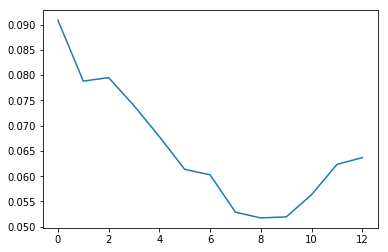

In [0]:
unet_2 = UNet(n_channels=3, n_classes=1).to('cuda')
unet_2.apply(weight_init)
train_loop_find(unet_2, 1, lr = 0.0001)
train_loop_find(unet_2, 1, lr = 0.0002)
train_loop_find(unet_2, 1, lr = 0.0004)
train_loop_find(unet_2, 1, lr = 0.0006)
train_loop_find(unet_2, 1, lr = 0.0008)
train_loop_find(unet_2, 1, lr = 0.001)
train_loop_find(unet_2, 1, lr = 0.002)
train_loop_find(unet_2, 1, lr = 0.004)
train_loop_find(unet_2, 1, lr = 0.006)
train_loop_find(unet_2, 1, lr = 0.008)
train_loop_find(unet_2, 1, lr = 0.01)
train_loop_find(unet_2, 1, lr = 0.02)
train_loop_find(unet_2, 1, lr = 0.04)

plt.plot(find_losses)

In [0]:
unet_2 = UNet(n_channels=3, n_classes=1).to('cuda')
unet_2.apply(weight_init)

val_losses = []
train_losses = []
accuracies = []

### This UNet has ~13.4 Million trainable parameters


In [0]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_params(unet_2)

13395329

In [0]:
bce_loss = torch.nn.BCEWithLogitsLoss()

# Train

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.57it/s]


val_loss: 0.26824545274178185 | accuracy: 0.5700482261025658 | train_loss: 0.3003506362438202


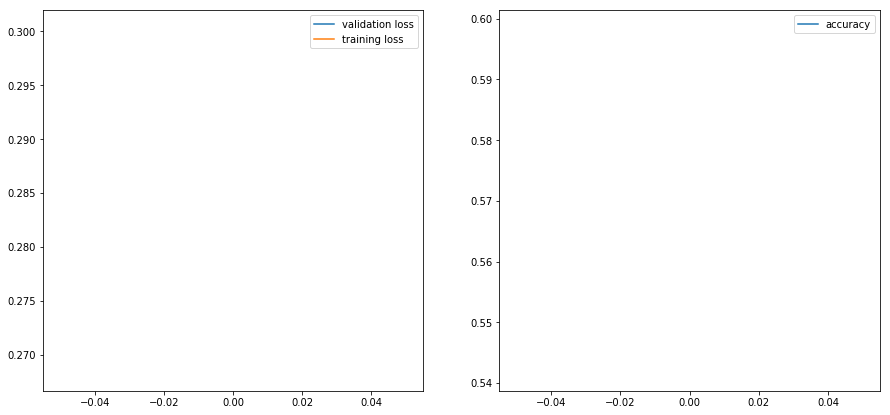

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.66it/s]


val_loss: 0.4047764389713605 | accuracy: 0.5130551387431721 | train_loss: 0.2991101145744324


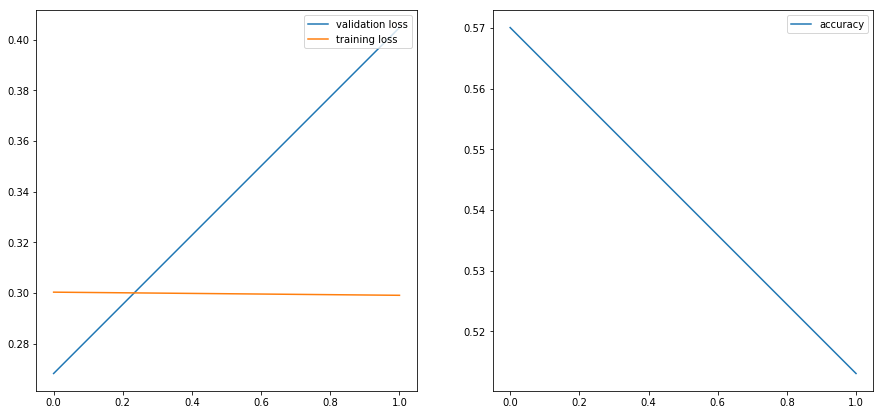

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.64it/s]


val_loss: 0.30306583528717357 | accuracy: 0.4962301462686931 | train_loss: 0.2544076442718506


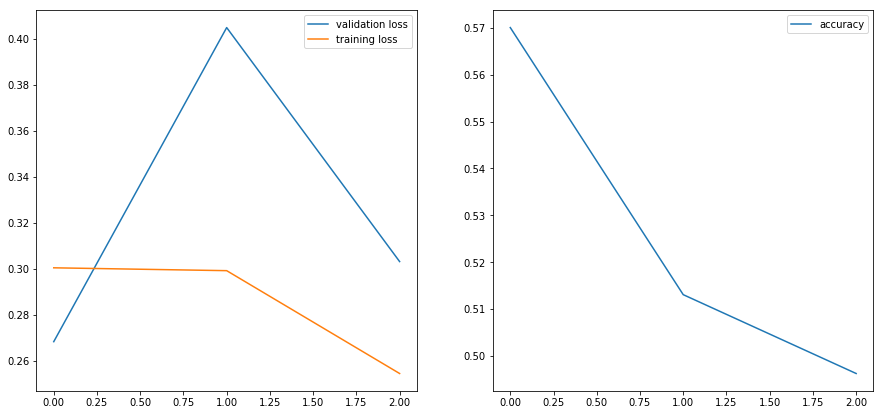

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.65it/s]


val_loss: 0.25591593368599813 | accuracy: 0.5728724804396431 | train_loss: 0.20381271839141846


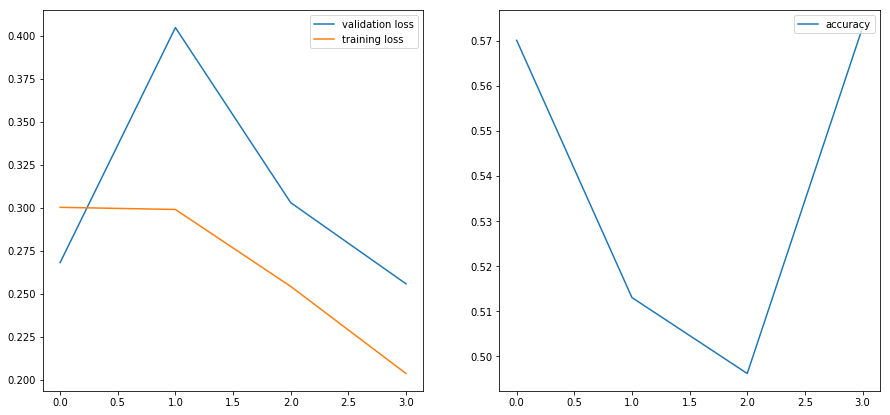

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.62it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.2281376551091671 | accuracy: 0.5661111638562094 | train_loss: 0.1783229261636734


100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.64it/s]


val_loss: 0.2378753835707903 | accuracy: 0.5767756244043509 | train_loss: 0.1677108258008957


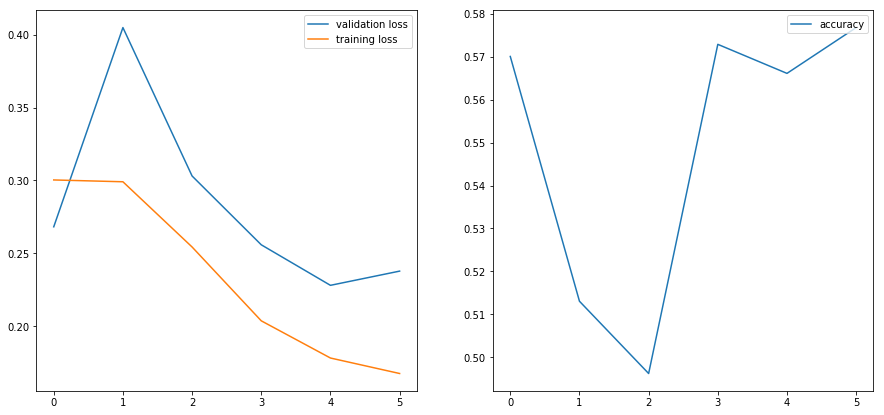

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.56it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.21117698186387618 | accuracy: 0.557659073031197 | train_loss: 0.15573056042194366


100%|██████████| 80/80 [02:07<00:00,  1.60s/it]
150it [00:08, 18.68it/s]


val_loss: 0.20463197813058892 | accuracy: 0.6092822139260049 | train_loss: 0.14545582234859467


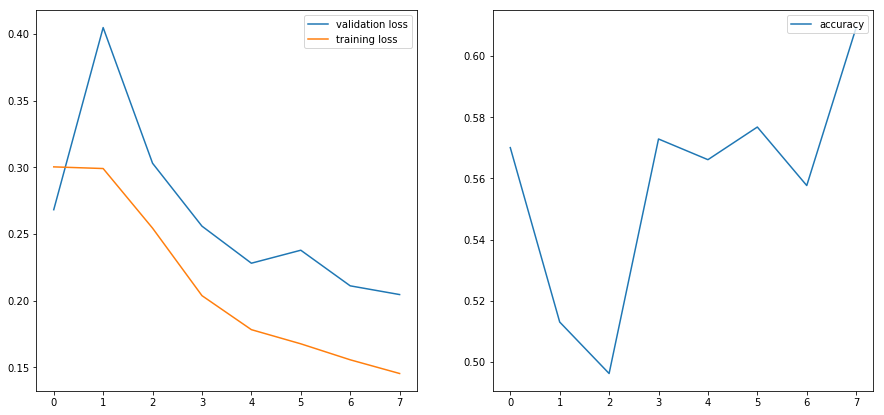

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.64it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.19056773259304463 | accuracy: 0.6519478117798766 | train_loss: 0.13413698971271515


100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.62it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.18258874384686352 | accuracy: 0.6736330929592562 | train_loss: 0.12952391803264618


100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.51it/s]


val_loss: 0.18611187793935338 | accuracy: 0.6463511774782091 | train_loss: 0.1291118860244751


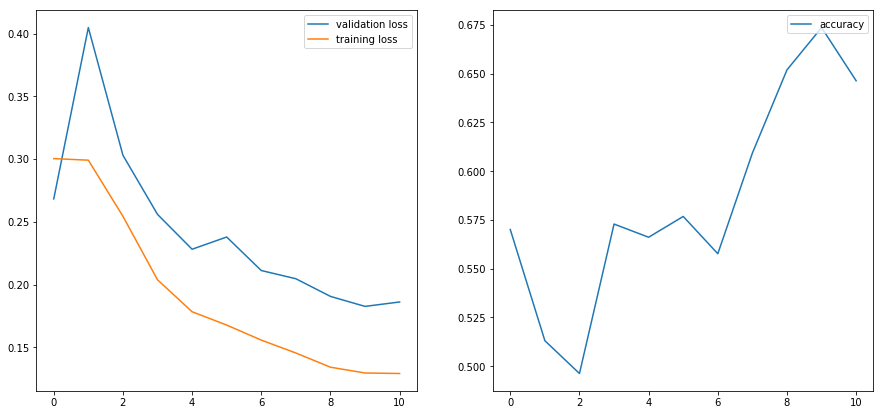

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.54it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.17848731185309588 | accuracy: 0.6529172718649109 | train_loss: 0.12236969918012619


100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 21.17it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1780771987947325 | accuracy: 0.6509716939460486 | train_loss: 0.11948374658823013


100%|██████████| 80/80 [02:07<00:00,  1.60s/it]
150it [00:08, 18.60it/s]


val_loss: 0.18833242738929887 | accuracy: 0.6369142067432404 | train_loss: 0.11748917400836945


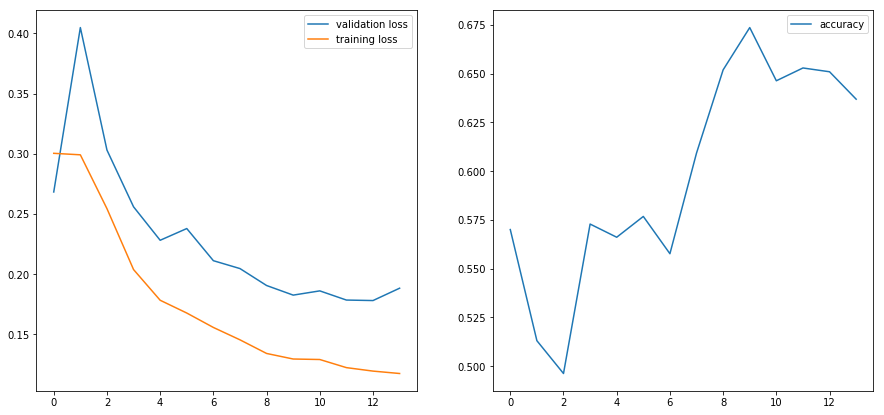

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.61it/s]


val_loss: 0.17206769377614062 | accuracy: 0.6920739758014679 | train_loss: 0.11580663919448853


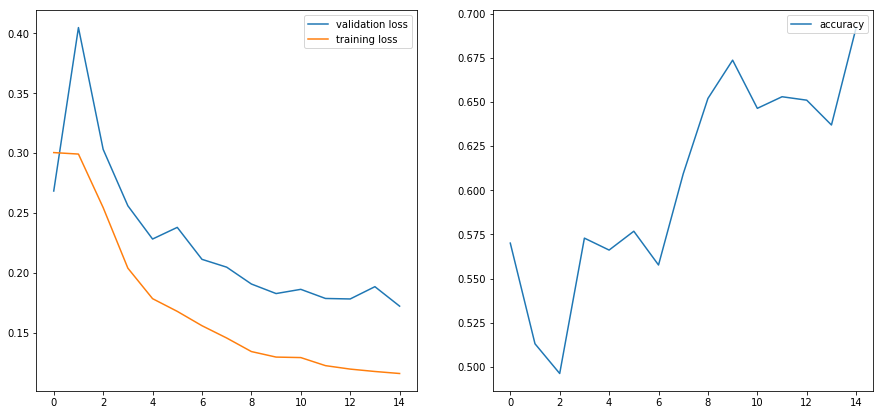

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.57it/s]


val_loss: 0.18986884156242012 | accuracy: 0.6589458427880891 | train_loss: 0.13559944927692413


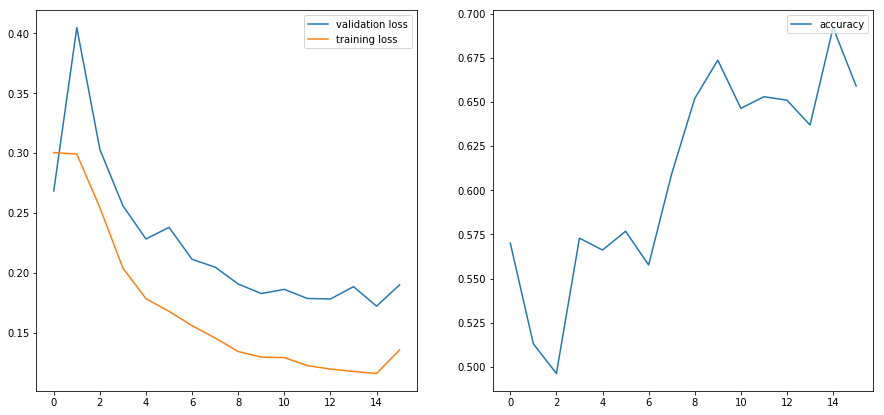

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.48it/s]


val_loss: 0.2244067893953373 | accuracy: 0.5989685956388712 | train_loss: 0.15735389292240143


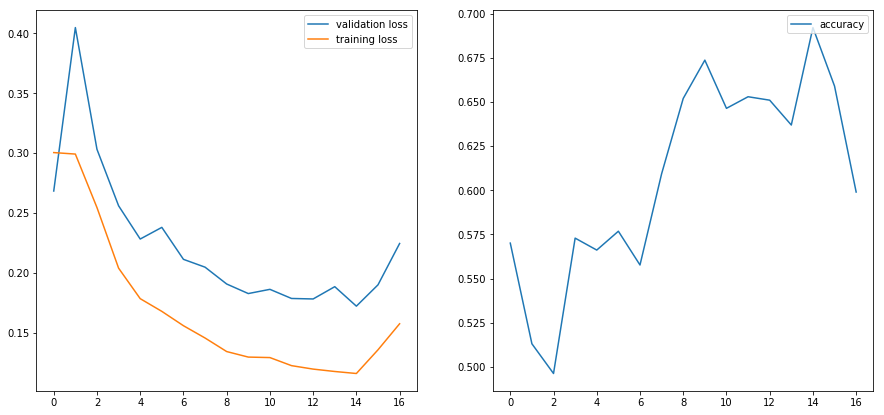

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 21.19it/s]


val_loss: 0.22310632061213254 | accuracy: 0.5628058621920354 | train_loss: 0.149807870388031


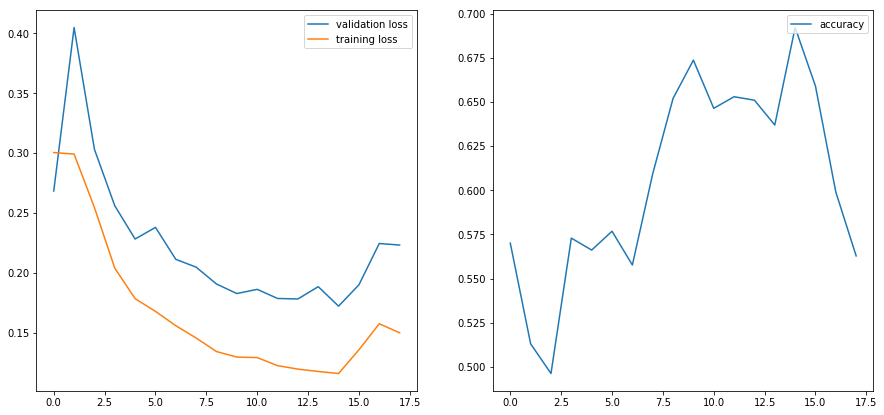

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.46it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.18797166572883725 | accuracy: 0.6326350439153612 | train_loss: 0.13468995690345764


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.50it/s]


val_loss: 0.17081795375794173 | accuracy: 0.6680742182815448 | train_loss: 0.12422899156808853


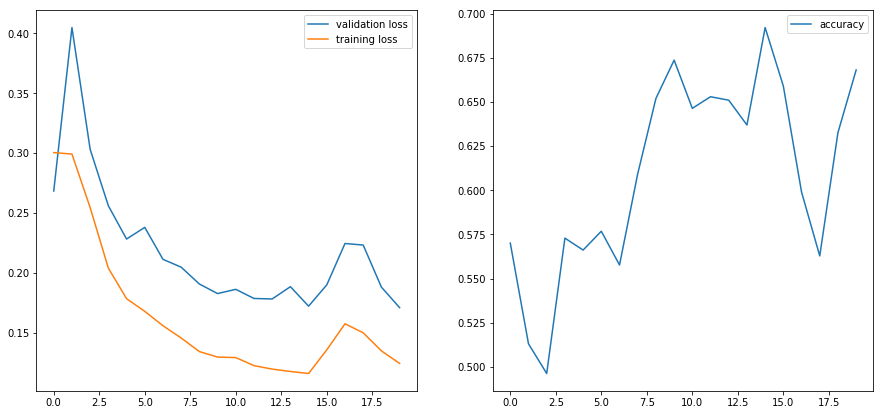

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.51it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1605584773886949 | accuracy: 0.6924706177413463 | train_loss: 0.12190353125333786


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.54it/s]


val_loss: 0.17355368279541533 | accuracy: 0.6863704270295178 | train_loss: 0.11599427461624146


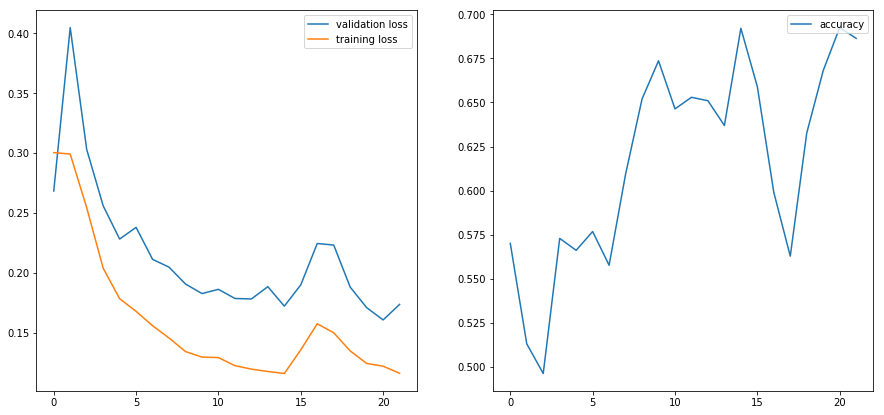

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.48it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1936880662975212 | accuracy: 0.6722937201584379 | train_loss: 0.110567107796669


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.63it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.16439079569963116 | accuracy: 0.6855779746795694 | train_loss: 0.10715887695550919


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.53it/s]


val_loss: 0.16770486979124447 | accuracy: 0.6699354326996642 | train_loss: 0.10657843202352524


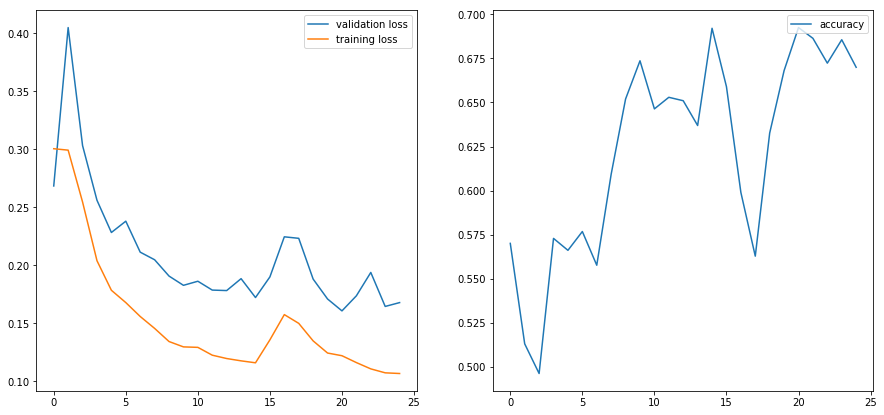

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.50it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.17299167982613048 | accuracy: 0.6917773078692456 | train_loss: 0.1036357507109642


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.43it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.157040568459779 | accuracy: 0.7130592876672744 | train_loss: 0.10459523648023605


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.57it/s]


val_loss: 0.1707638756558299 | accuracy: 0.6841550310825308 | train_loss: 0.10234355181455612


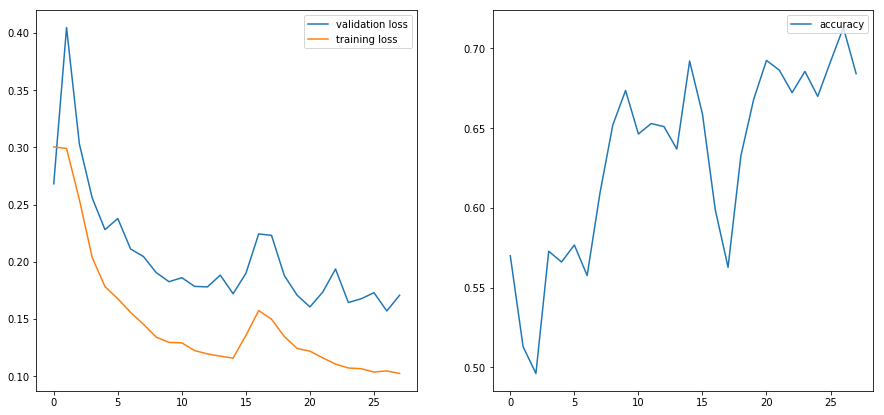

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.44it/s]


val_loss: 0.17355419200845063 | accuracy: 0.6902729427441955 | train_loss: 0.09859579056501389


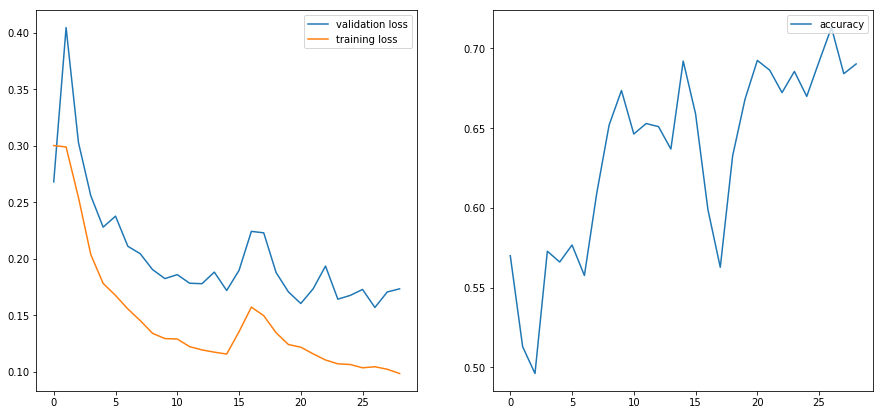

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.49it/s]


val_loss: 0.20429435615427793 | accuracy: 0.675681719345351 | train_loss: 0.11514370888471603


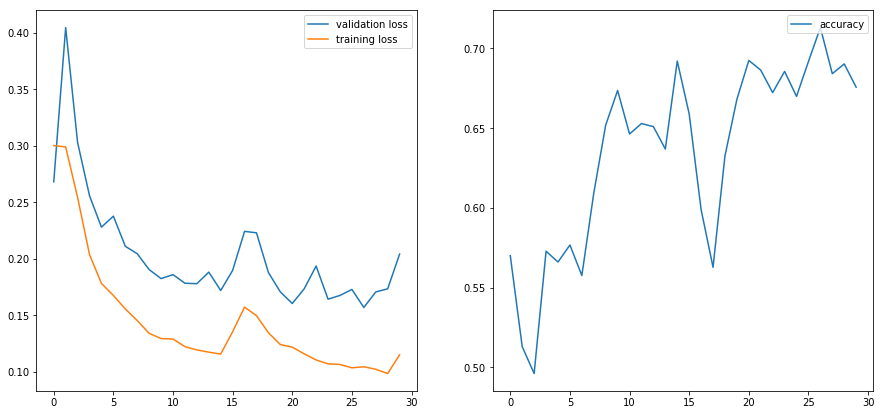

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.45it/s]


val_loss: 0.2003541348874569 | accuracy: 0.6742297760319585 | train_loss: 0.13609714806079865


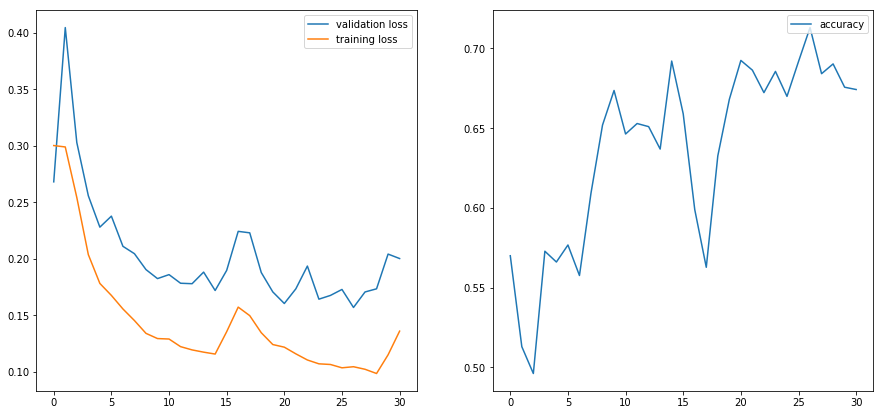

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.58it/s]


val_loss: 0.19871649115656814 | accuracy: 0.655141135379672 | train_loss: 0.12678319215774536


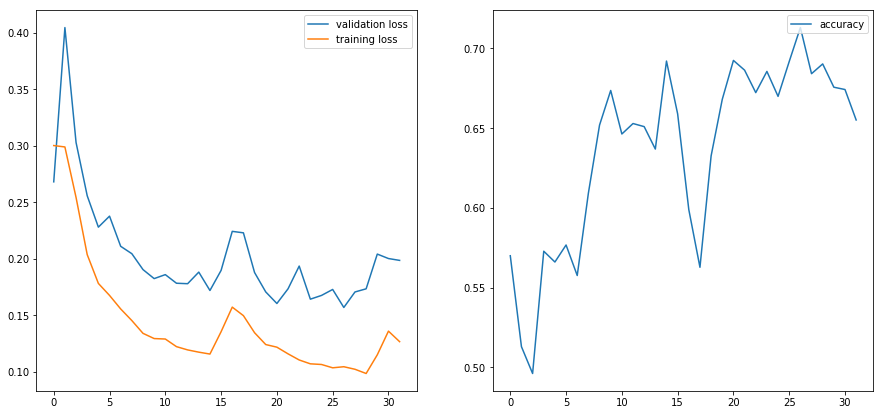

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.44it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1831777859479189 | accuracy: 0.6789546672006448 | train_loss: 0.12065278738737106


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.54it/s]


val_loss: 0.1696378144963334 | accuracy: 0.71069002289325 | train_loss: 0.11210586875677109


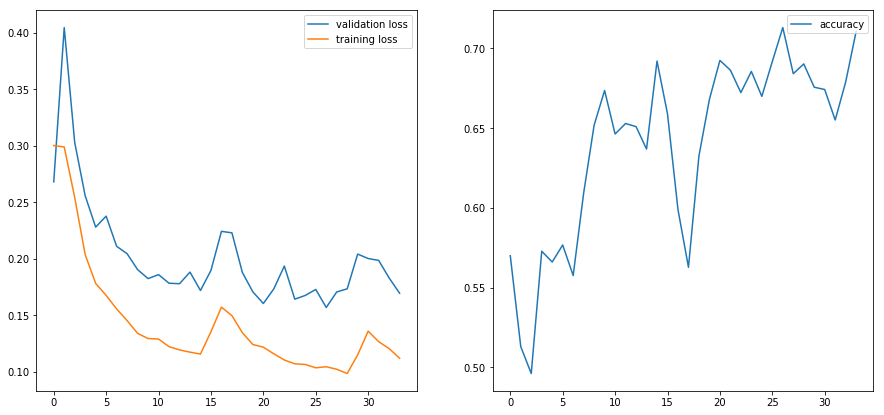

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.51it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.17578823473614952 | accuracy: 0.6615517523139716 | train_loss: 0.11116541922092438


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.52it/s]


val_loss: 0.1885062827914953 | accuracy: 0.6708143854513764 | train_loss: 0.10413720458745956


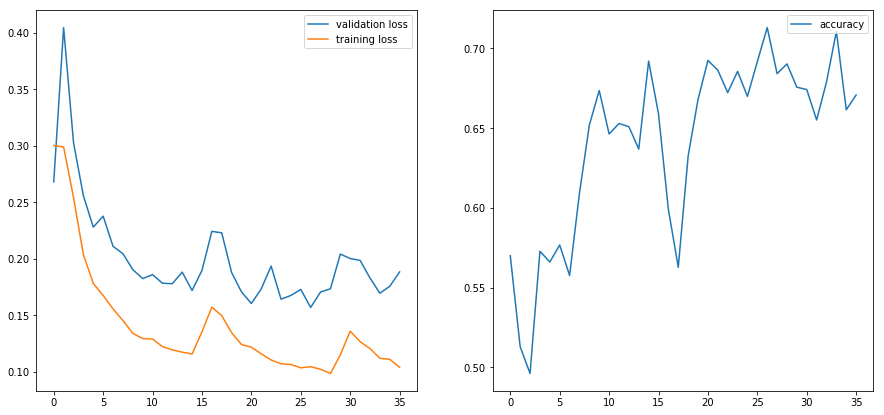

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.47it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15214879548487564 | accuracy: 0.71524455430607 | train_loss: 0.09936825931072235


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.51it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.18062326369496684 | accuracy: 0.698001689662536 | train_loss: 0.09561683982610703


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.46it/s]


val_loss: 0.15876328539103268 | accuracy: 0.7008833081151048 | train_loss: 0.09506707638502121


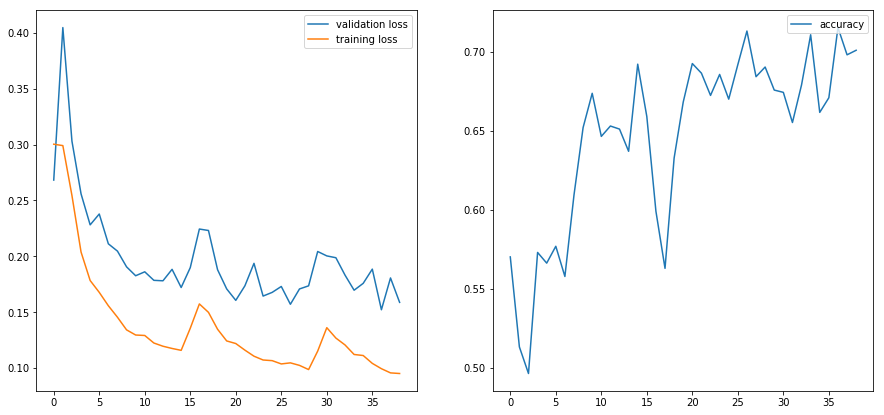

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.58it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.16353060502558947 | accuracy: 0.7058690238061051 | train_loss: 0.09547703713178635


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.42it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.16317938991822303 | accuracy: 0.7005033032596111 | train_loss: 0.09311756491661072


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 21.08it/s]


val_loss: 0.17095154543407262 | accuracy: 0.692337193073084 | train_loss: 0.09016391634941101


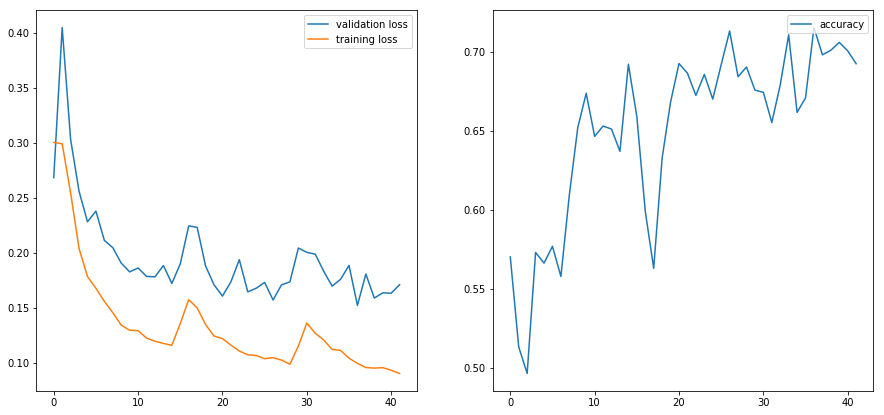

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.42it/s]


val_loss: 0.16460279431349287 | accuracy: 0.717295945653071 | train_loss: 0.09110704064369202


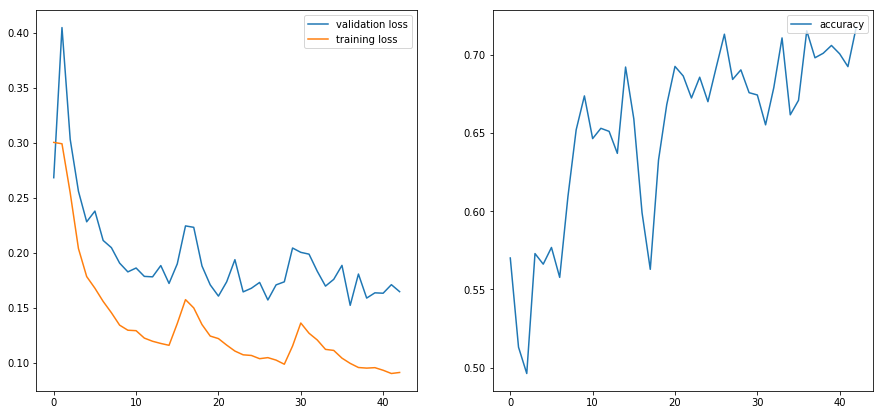

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.47it/s]


val_loss: 0.15892690589961905 | accuracy: 0.6942497405161461 | train_loss: 0.10109130293130875


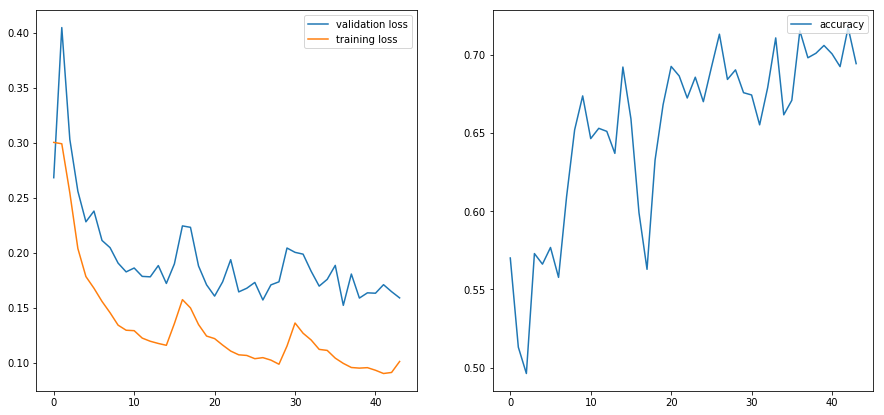

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.46it/s]


val_loss: 0.17169838082666197 | accuracy: 0.6780399267189204 | train_loss: 0.1162218376994133


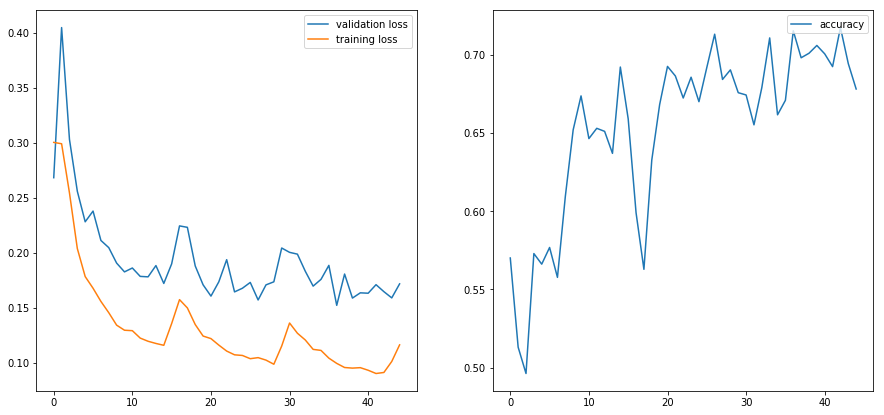

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.52it/s]


val_loss: 0.17301730124279857 | accuracy: 0.6701796515099704 | train_loss: 0.11036920547485352


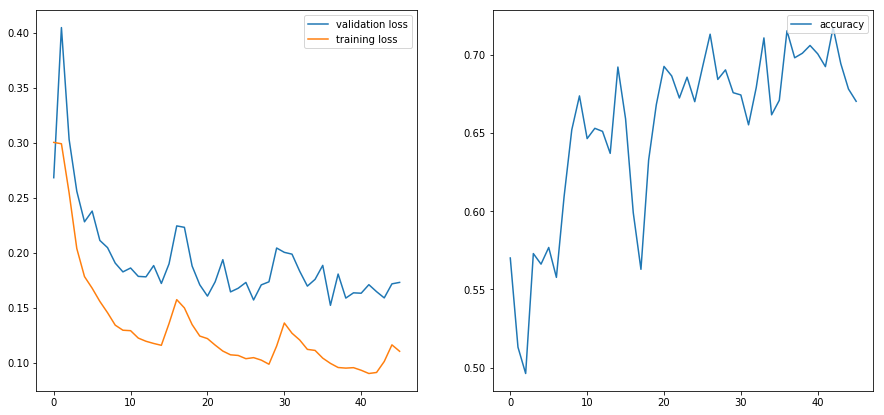

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.47it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1569006526035567 | accuracy: 0.706339080867668 | train_loss: 0.10572526603937149


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.52it/s]


val_loss: 0.21925865561080476 | accuracy: 0.6915676012635231 | train_loss: 0.10555743426084518


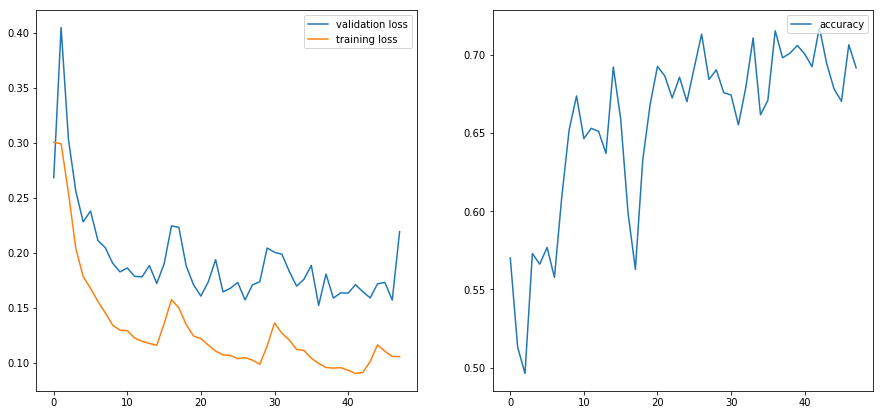

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.51it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.17003038081961375 | accuracy: 0.6540680246800185 | train_loss: 0.10117590427398682


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.49it/s]


val_loss: 0.1616805268327395 | accuracy: 0.698601939274619 | train_loss: 0.09576501697301865


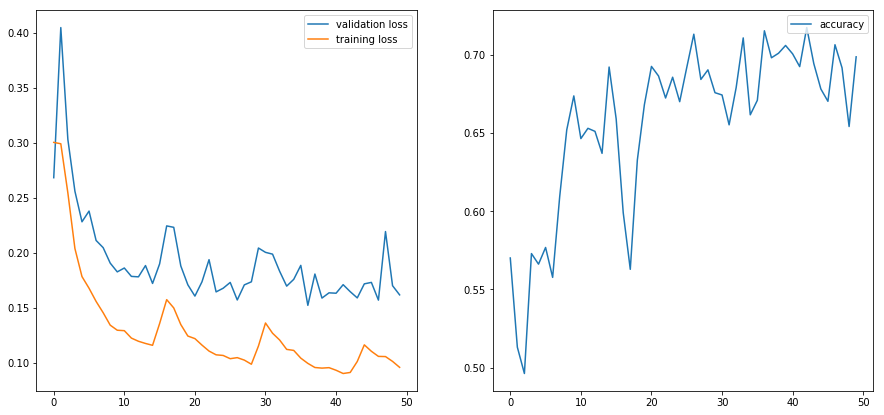

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.50it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15176654424052685 | accuracy: 0.7114966350343699 | train_loss: 0.09163708239793777


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.48it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.16296553203525643 | accuracy: 0.7293022985011339 | train_loss: 0.08878148347139359


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.45it/s]


val_loss: 0.1613531319765995 | accuracy: 0.713478073378404 | train_loss: 0.08978249877691269


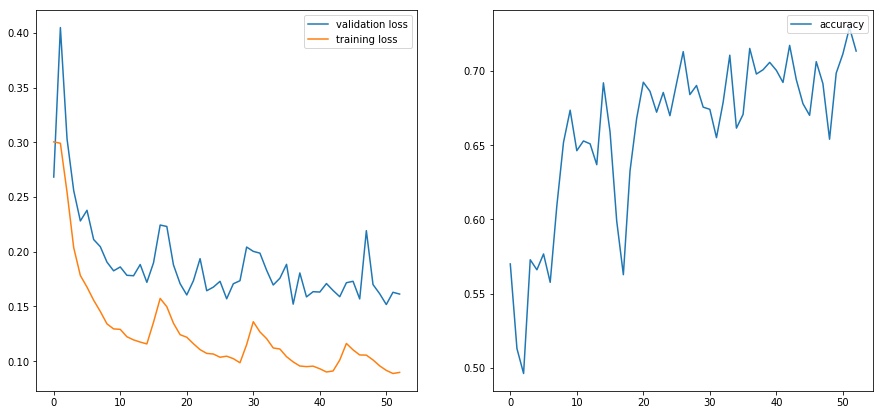

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.49it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1577234266527618 | accuracy: 0.7145434955259165 | train_loss: 0.08852428942918777


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.47it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15348445057092855 | accuracy: 0.7086186398814122 | train_loss: 0.08489884436130524


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.55it/s]


val_loss: 0.1456573344549785 | accuracy: 0.7325439578294755 | train_loss: 0.08720096200704575


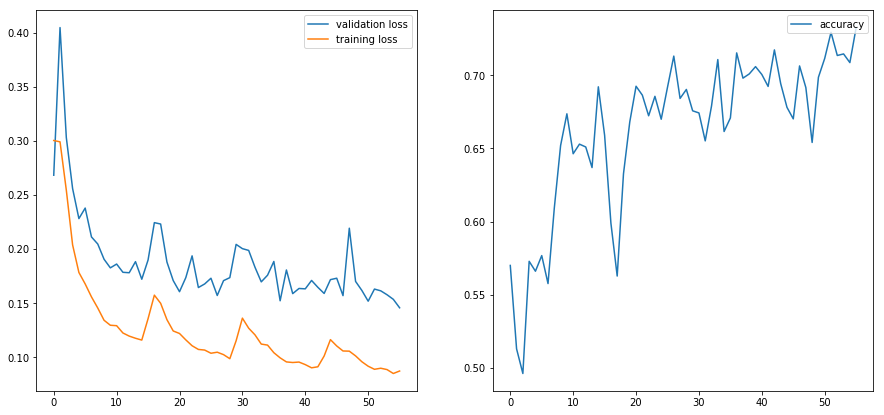

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:08, 18.52it/s]


val_loss: 0.16066376437277843 | accuracy: 0.71425022435685 | train_loss: 0.08448167890310287


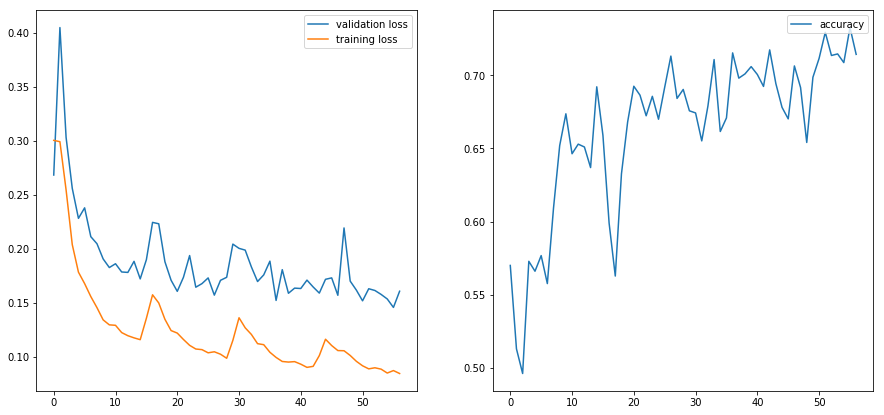

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.52it/s]


val_loss: 0.25512162618959944 | accuracy: 0.668875851292784 | train_loss: 0.09358822554349899


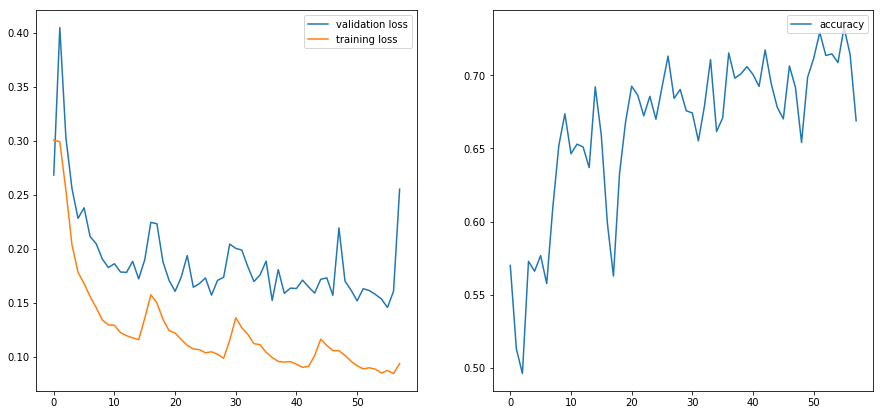

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.61it/s]


val_loss: 0.23138481416739523 | accuracy: 0.6392750502595057 | train_loss: 0.10952800512313843


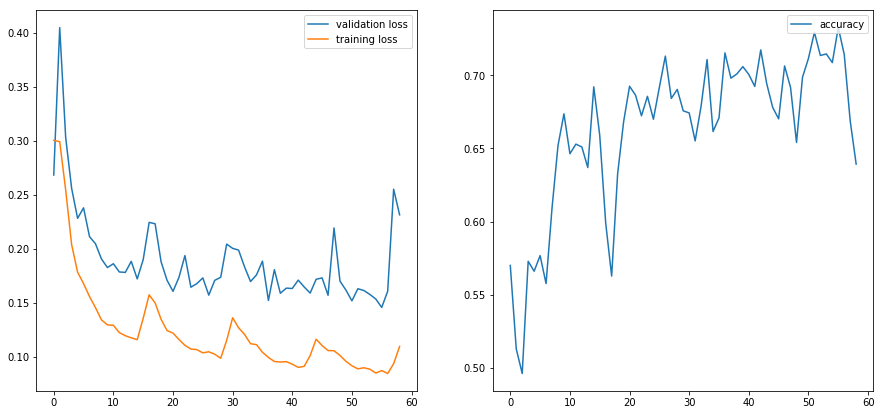

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.61it/s]


val_loss: 0.16465597150847316 | accuracy: 0.656095942473039 | train_loss: 0.10745465755462646


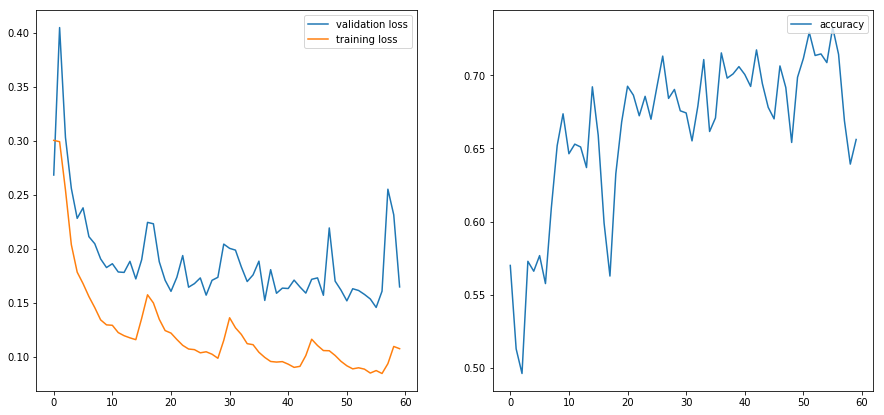

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.64it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.18575249277676145 | accuracy: 0.6523202523527046 | train_loss: 0.10171973705291748


100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.66it/s]


val_loss: 0.16091899760377903 | accuracy: 0.7296797206997871 | train_loss: 0.09647663682699203


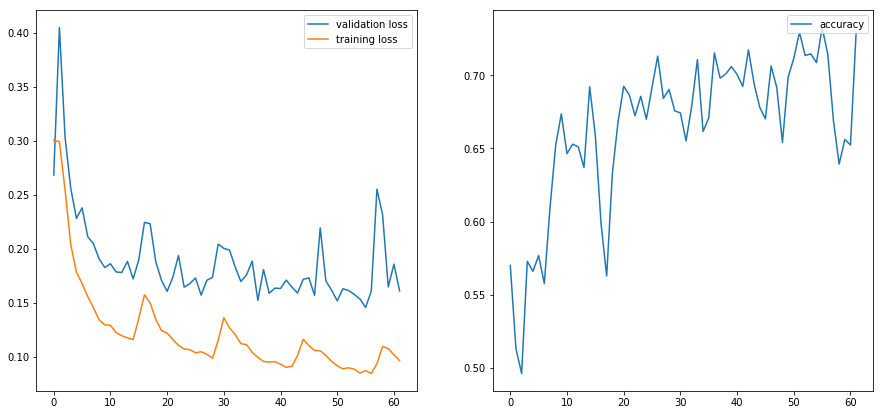

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.60it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.16160430767262976 | accuracy: 0.7065258588160699 | train_loss: 0.09082895517349243


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.63it/s]


val_loss: 0.15842445981378356 | accuracy: 0.7058104421865816 | train_loss: 0.0902145504951477


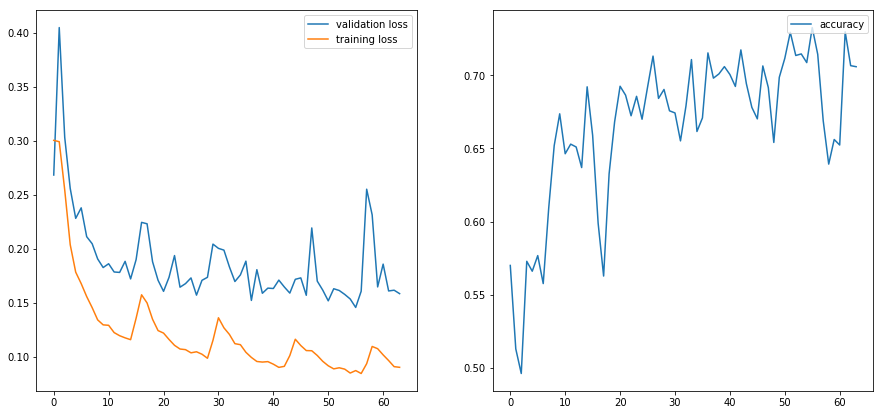

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.60it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15018442390641817 | accuracy: 0.7427074076980352 | train_loss: 0.08498670905828476


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.66it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1475818636175245 | accuracy: 0.7253840192655723 | train_loss: 0.08342790603637695


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.64it/s]


val_loss: 0.16815997823296736 | accuracy: 0.7163185066667695 | train_loss: 0.08039253205060959


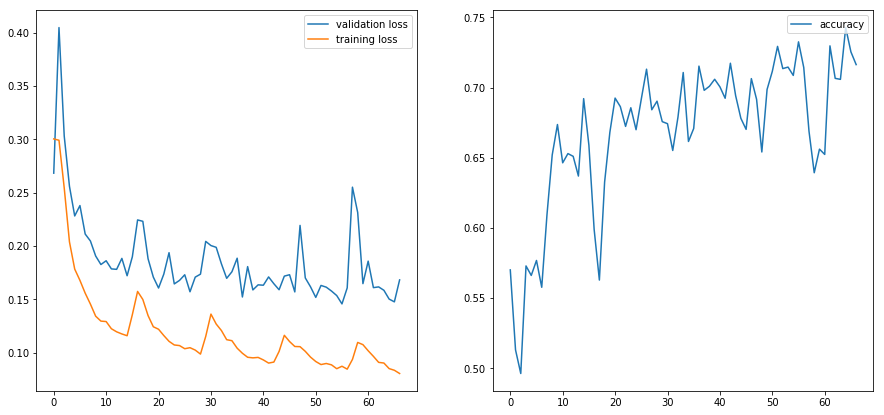

100%|██████████| 80/80 [02:07<00:00,  1.61s/it]
150it [00:08, 18.63it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15041821127291768 | accuracy: 0.7285983135799566 | train_loss: 0.07993122190237045


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.63it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15494141573552042 | accuracy: 0.7279902379711469 | train_loss: 0.07920800894498825


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:08, 18.63it/s]


val_loss: 0.14968340315390377 | accuracy: 0.7318371569613615 | train_loss: 0.07868580520153046


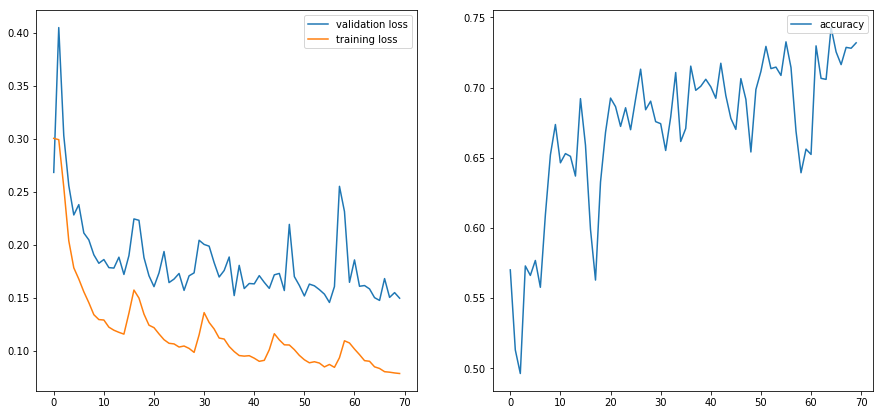

In [0]:
for i in range(5):
    train_loop(unet_2, epochs=1, lr=0.0001)
    train_loop(unet_2, epochs=1, lr=0.0005)
    train_loop(unet_2, epochs=1, lr=0.001)
    train_loop(unet_2, epochs=1, lr=0.0008)
    train_loop(unet_2, epochs=2, lr=0.0006)
    train_loop(unet_2, epochs=2, lr=0.0004)
    train_loop(unet_2, epochs=3, lr=0.0002)
    train_loop(unet_2, epochs=3, lr=0.0001)
    torch.save(unet_2.state_dict(), "unet_checkpoint_{}".format(i))

## Lower LR fine tuning with weight regularization

100%|██████████| 80/80 [02:09<00:00,  1.62s/it]
150it [00:07, 19.16it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.14868979121713588 | accuracy: 0.734964050501585 | train_loss: 0.08060673624277115


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:07, 19.18it/s]


val_loss: 0.1557534064538777 | accuracy: 0.737630914474527 | train_loss: 0.08094184845685959


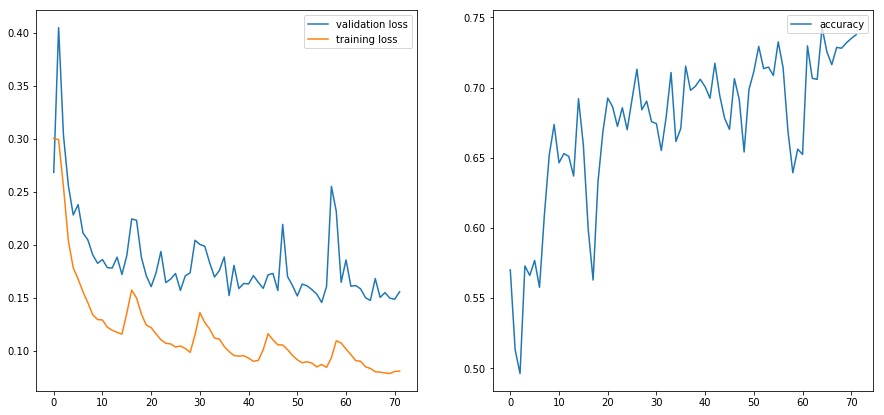

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:07, 19.16it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15671674493700266 | accuracy: 0.7222827251752217 | train_loss: 0.07762827724218369


100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:07, 19.16it/s]


val_loss: 0.155926857534796 | accuracy: 0.733204297957321 | train_loss: 0.07512293756008148


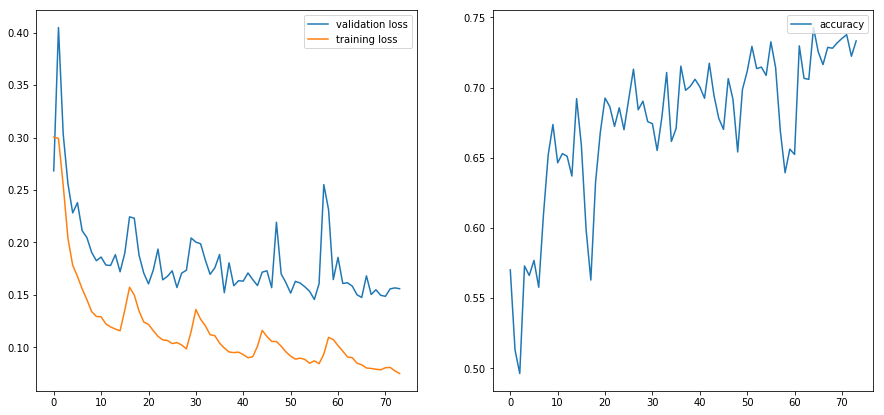

100%|██████████| 80/80 [02:09<00:00,  1.61s/it]
150it [00:07, 19.14it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.17763625538597505 | accuracy: 0.7175902308772008 | train_loss: 0.07802634686231613


100%|██████████| 80/80 [02:09<00:00,  1.61s/it]
150it [00:07, 19.18it/s]


val_loss: 0.1639254898407186 | accuracy: 0.7107590356965859 | train_loss: 0.07930275797843933


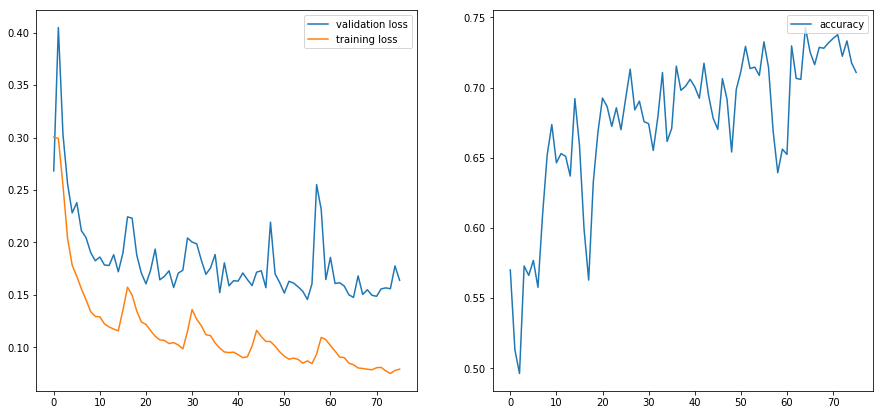

100%|██████████| 80/80 [02:08<00:00,  1.61s/it]
150it [00:07, 19.15it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.16451090992738804 | accuracy: 0.7228977125386397 | train_loss: 0.0746116116642952


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:07, 19.17it/s]


val_loss: 0.1532900300125281 | accuracy: 0.7394738128781319 | train_loss: 0.07678571343421936


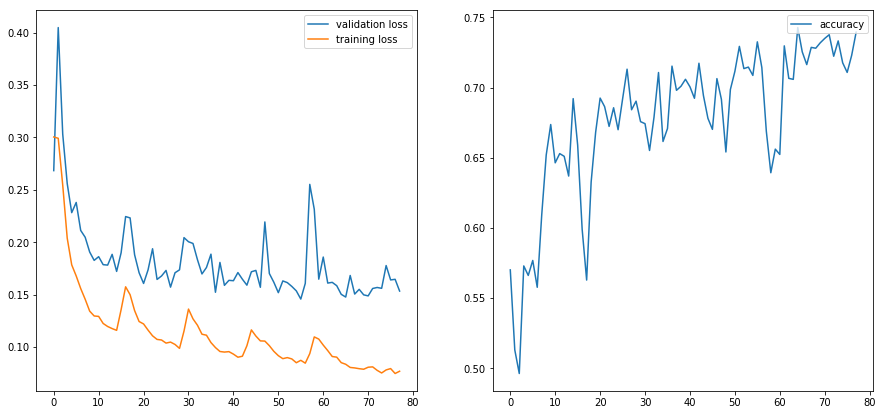

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:07, 19.11it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1711237824894488 | accuracy: 0.705545281774054 | train_loss: 0.07753454148769379


100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:07, 19.13it/s]


val_loss: 0.17872190772245328 | accuracy: 0.7234091451123823 | train_loss: 0.07645255327224731


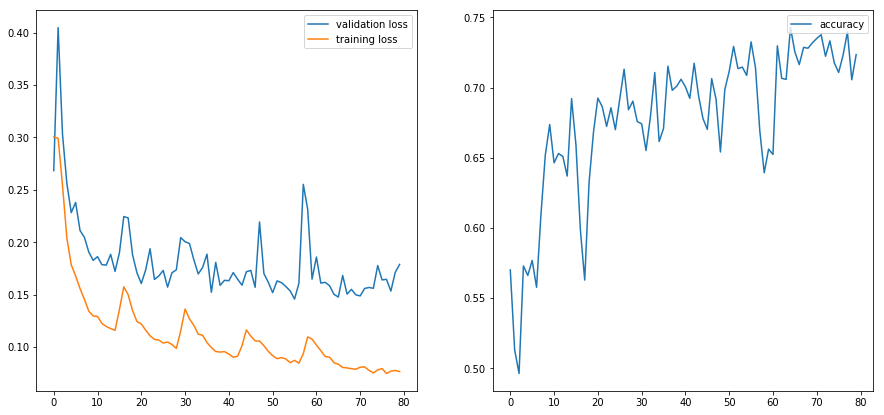

100%|██████████| 80/80 [02:08<00:00,  1.62s/it]
150it [00:07, 19.12it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.15869068076678863 | accuracy: 0.7291451784720023 | train_loss: 0.07465985417366028


100%|██████████| 80/80 [02:09<00:00,  1.61s/it]
150it [00:07, 19.08it/s]


val_loss: 0.15774537686103335 | accuracy: 0.7308511685828368 | train_loss: 0.07347574084997177


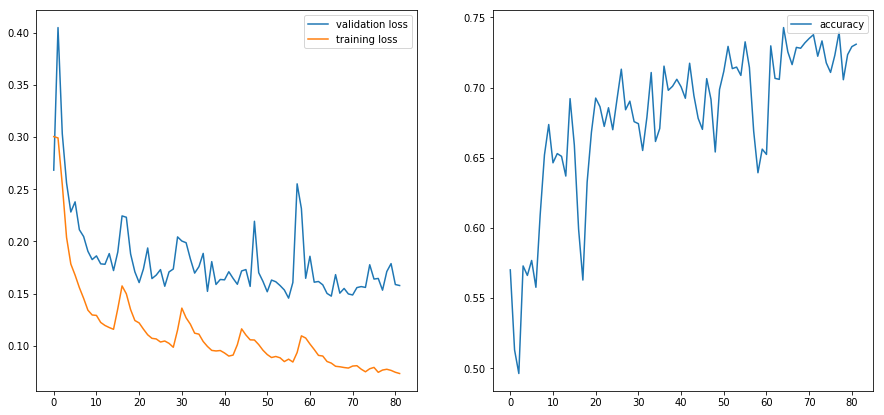

In [0]:
for j in range(3):
    train_loop(unet_2, epochs=2, lr=0.0002, weight_decay=0.00001)
    train_loop(unet_2, epochs=2, lr=0.0001, weight_decay=0.00001)

torch.save(unet_2.state_dict(), "unet_checkpoint_regularized")

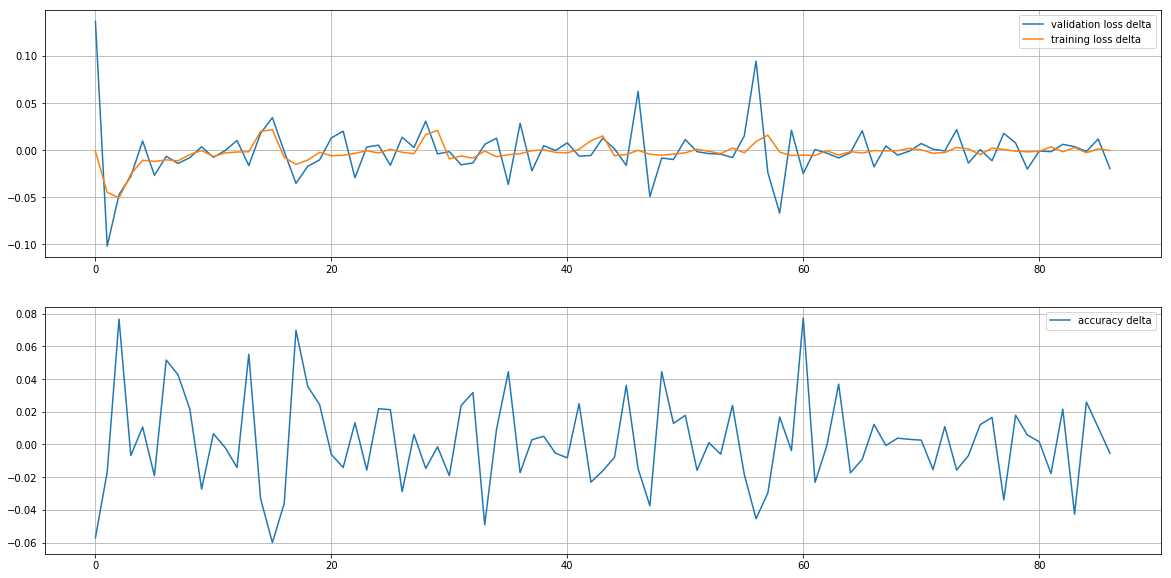

In [0]:
# val_loss_deltas = [v2 - v1 for v1, v2 in zip(val_losses, val_losses[1:])]
# train_loss_deltas = [t2 - t1 for t1, t2 in zip(train_losses, train_losses[1:])]
# acc_deltas = [a2 - a1 for a1, a2 in zip(accuracies, accuracies[1:])]

# plt.figure(figsize=(20, 10))
# plt.subplot(2, 1, 1)
# plt.plot(val_loss_deltas, label="validation loss delta")
# plt.plot(train_loss_deltas, label="training loss delta")
# plt.grid(b=True, which='both')
# plt.legend(loc='upper right')
# plt.subplot(2, 1, 2)
# plt.plot(acc_deltas, label="accuracy delta")
# plt.grid(b=True, which='both')
# plt.legend(loc='upper right')

# Final plots for losses and accuracy (IoU) metric

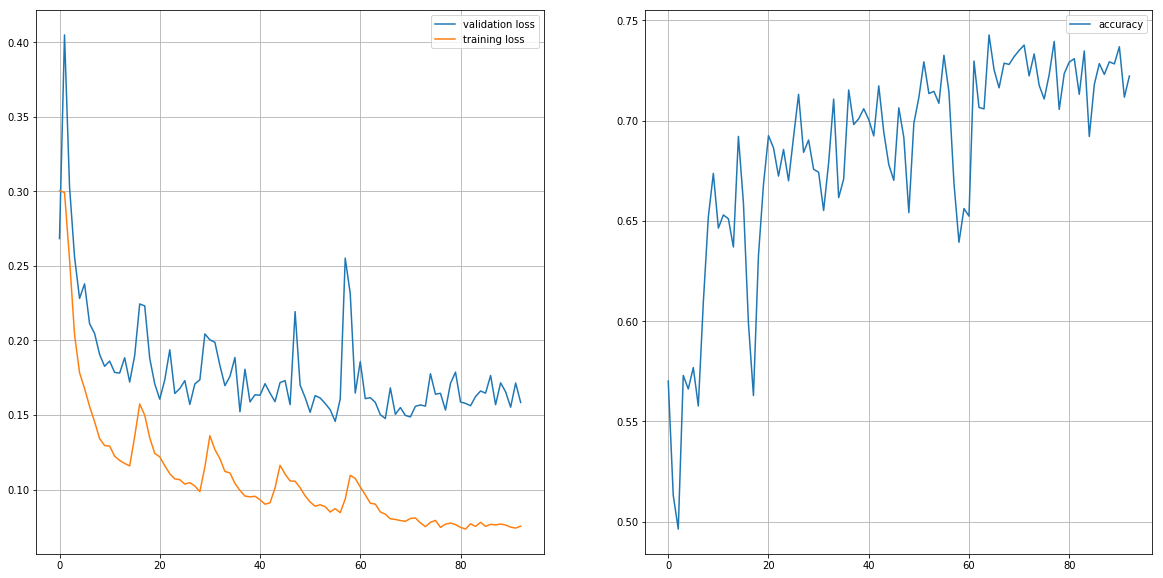

In [0]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(val_losses, label='validation loss')
plt.plot(train_losses, label='training loss')
plt.grid(b=True, which='both')
plt.legend(loc='upper right') 
plt.subplot(2, 1, 2) 
plt.plot(accuracies, label="accuracy")
plt.grid(b=True, which='both')
plt.legend(loc='upper right')
plt.show()

## Some segmentation examples

In [0]:
unet_2.load_state_dict(torch.load("/content/drive/My Drive/DATA/unet_checkpoint_regularized"))
unet_2.eval()

In [0]:
def show_random_pairs(model, num_examples=3):
    plt.figure(figsize=(20, 5*num_examples))
    for i, idx in enumerate(np.random.permutation(len(val_img_x))[:num_examples]):
        plt.subplot(num_examples, 3, 3*i + 1)
        plt.imshow(val_img_y[idx])
        plt.subplot(num_examples, 3, 3*i + 2)
        plt.imshow(val_img_x[idx].permute(1, 2, 0))
        plt.subplot(num_examples, 3, 3*i + 3)
        with torch.no_grad():
            preds = model(val_img_x[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'))

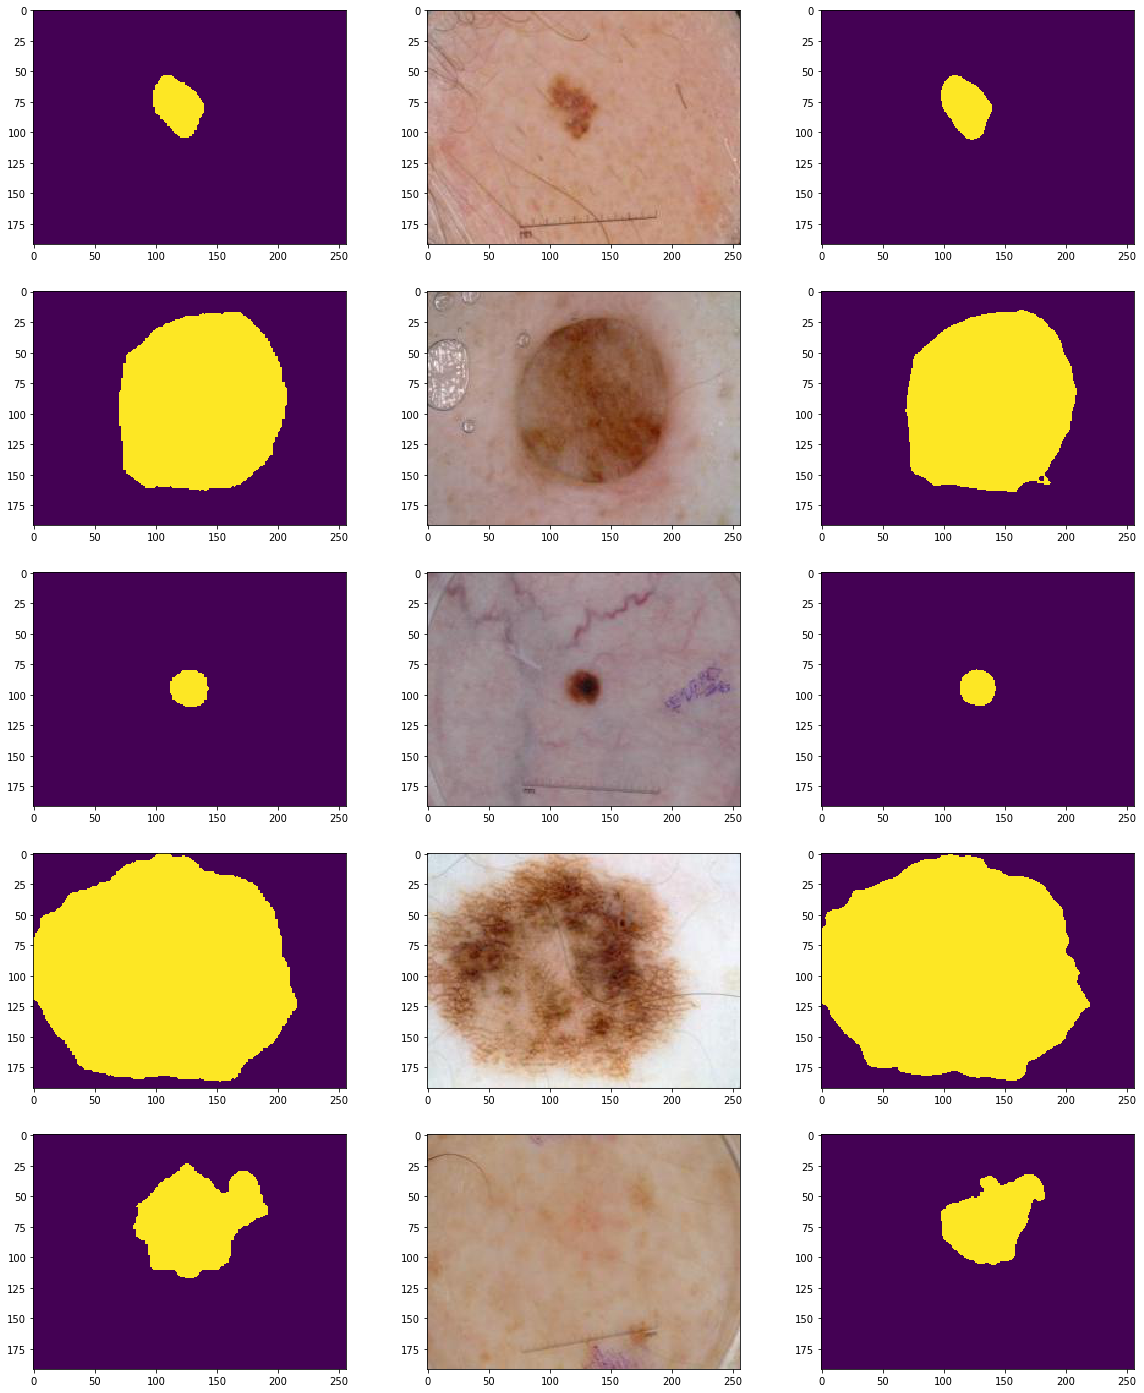

In [0]:
show_random_pairs(unet_2, 5)

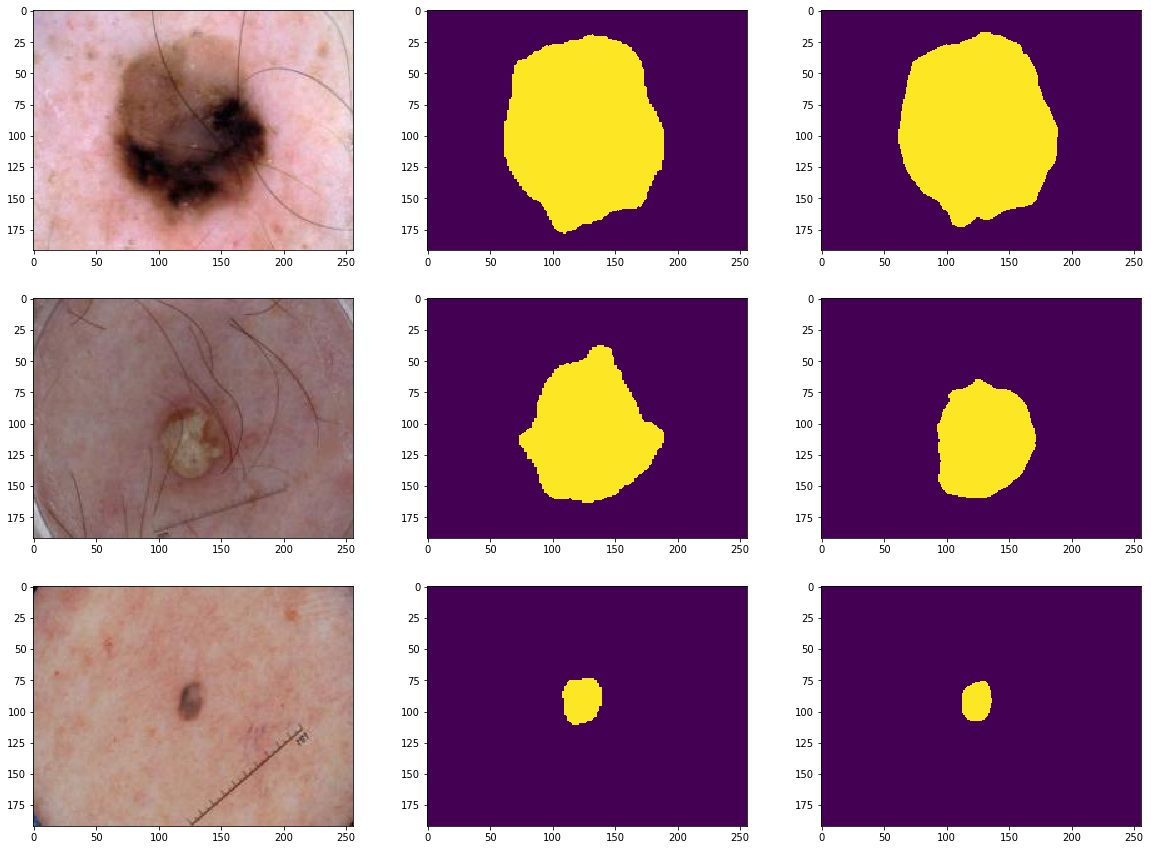

In [0]:
show_random_pairs(unet_2, 3)

# Evaluate model on Test Set

In [0]:
def get_test_loss_accuracy_IoU(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm.tqdm(zip(test_img_x, test_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = IoU_accuracy(preds.squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

def get_test_loss_accuracy_Dice(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm.tqdm(zip(test_img_x, test_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = Dice_accuracy(preds.squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

In [0]:
t_loss, t_acc = get_test_loss_accuracy_IoU(unet_2)
print("\nLoss: {} | Accuracy (IoU): {}".format(t_loss, t_acc))

600it [00:27, 21.94it/s]


Loss: 0.23148267226992175 | Accuracy (IoU): 0.709416224702727


In [0]:
t_loss, t_acc = get_test_loss_accuracy_Dice(unet_2)
print("\nLoss: {} | Accuracy (Dice): {}".format(t_loss, t_acc))

600it [00:28, 20.72it/s]


Loss: 0.23148267226992175 | Accuracy (Dice): 0.8037029385853869


## Test Accuracy
### (Dice Coefficient) = 80.37%
### (IoU) = 70.94%

## Sort Test data by loss

In [0]:
def get_sorted_loss_images(model, X, Y, device='cuda'):
    model.eval()

    idx_losses = []

    with torch.no_grad():
        for idx, (x, y) in tqdm.tqdm(enumerate(zip(X, Y))):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            idx_losses.append((loss.item(), idx))
    
    idx_losses.sort()

    return idx_losses

In [0]:
idx_loss_test = get_sorted_loss_images(unet_2, test_img_x, test_img_y)

## Show samples with most and those with least accuracy

In [0]:
def show_pairs_max(model, idx_losses, X, Y, num=5):
    plt.figure(figsize=(20, 5*num))
    for i, (loss, idx) in enumerate(reversed(idx_losses)):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(Y[idx])
        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(X[idx].permute(1, 2, 0))
        plt.subplot(num, 3, 3*i + 3)
        with torch.no_grad():
            preds = model(X[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'))

        if i >= num-1:
            break

def show_pairs_min(model, idx_losses, X, Y, num=5):
    plt.figure(figsize=(20, 5*num))
    for i, (loss, idx) in enumerate(idx_losses):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(Y[idx], label='test')
        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(X[idx].permute(1, 2, 0), label='Input Image')
        plt.subplot(num, 3, 3*i + 3)
        with torch.no_grad():
            preds = model(X[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'), label='model prediction')

        if i >= num-1:
            break

## Least Accurate predictions

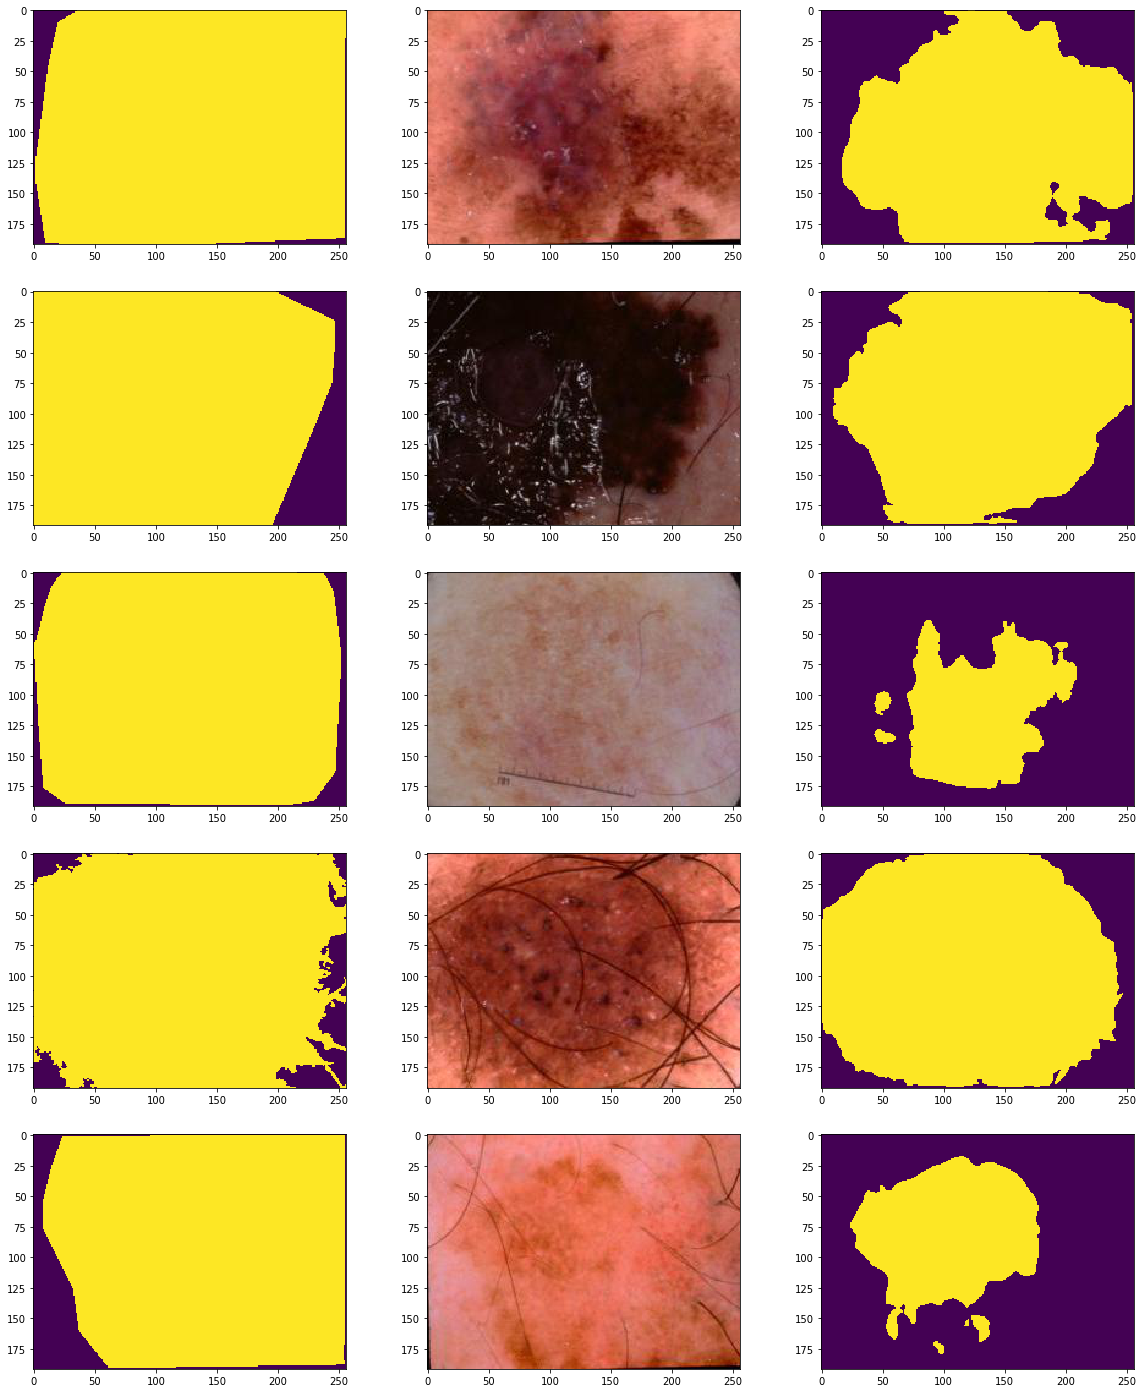

In [0]:
show_pairs_max(unet_2, idx_loss_test, test_img_x, test_img_y)

## Most Accurate Predictions

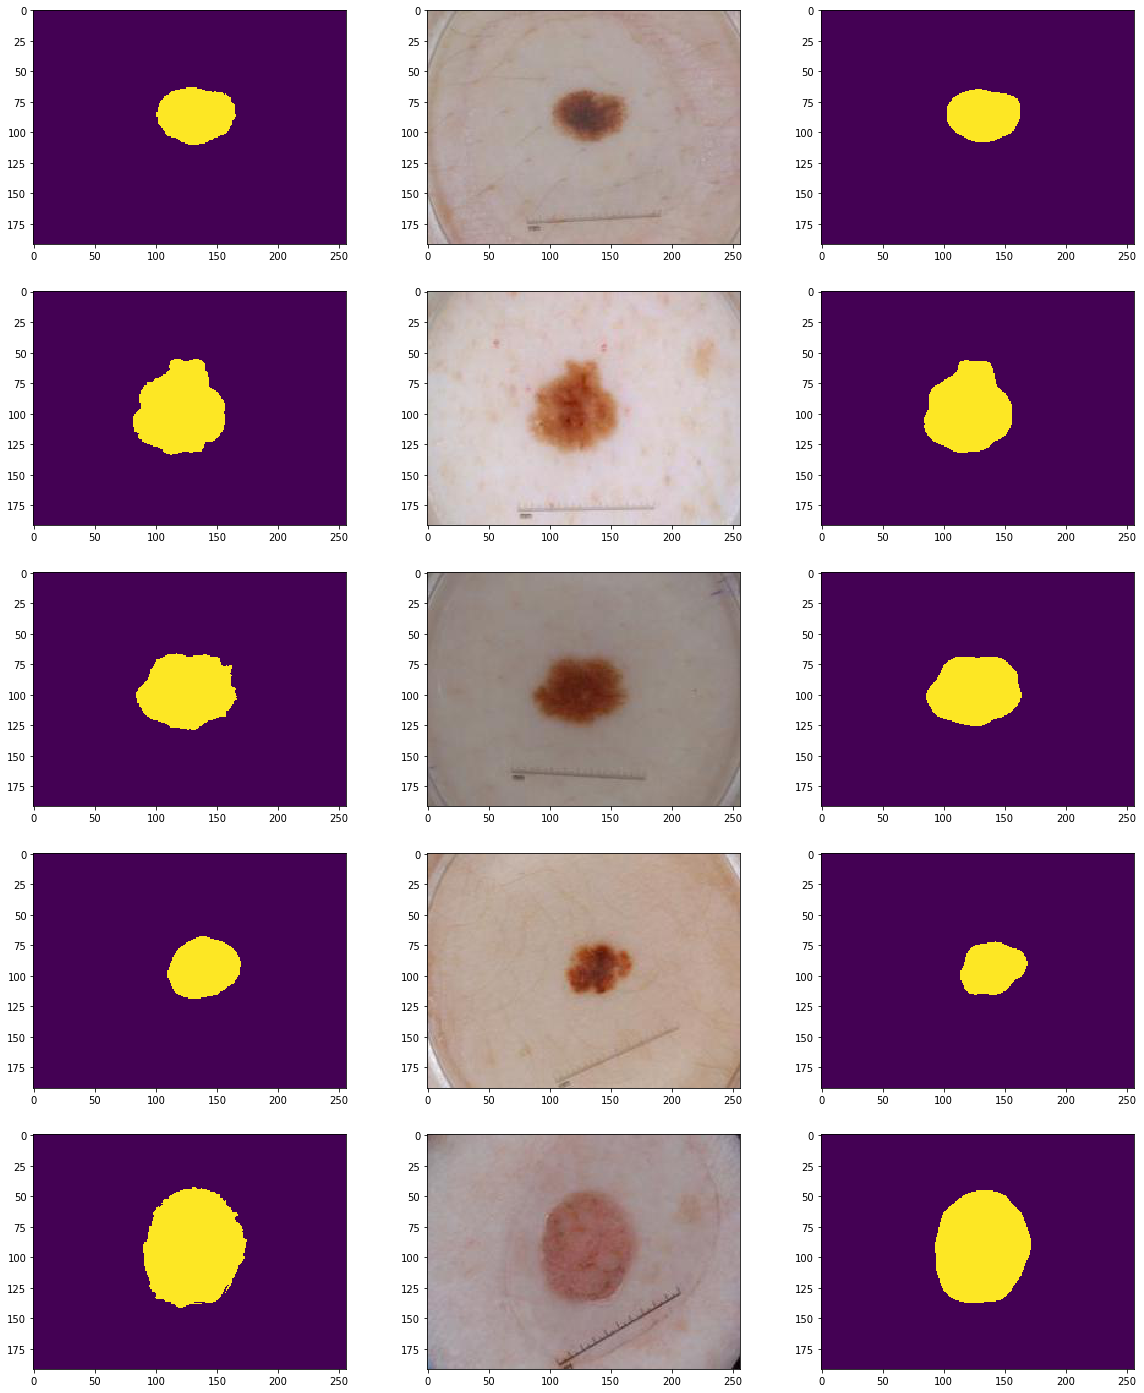

In [0]:
show_pairs_min(unet_2, idx_loss_test, test_img_x, test_img_y)